In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!pip install "tensorflow<2.9.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.9 MB 34 kB/s 
     |████████████████████████████████| 1.4 MB 38.2 MB/s 
     |████████████████████████████████| 462 kB 42.7 MB/s 
     |████████████████████████████████| 5.8 MB 32.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully un

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [6]:
!unzip "/content/drive/MyDrive/cashew.zip"

Archive:  /content/drive/MyDrive/cashew.zip
Created by UltraZip
   creating: quality-detection-2-v1-export/
   creating: quality-detection-2-v1-export/testing/
   creating: quality-detection-2-v1-export/testing/cashew-alive/
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (1).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (10).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (100).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (101).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (102).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (103).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (104).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/cashew-alive (105).jpg  
  inflating: quality-detection-2-v1-export/testing/cashew-alive/ca

In [7]:
!ls

drive  quality-detection-2-v1-export  sample_data


In [8]:
root_dir = 'quality-detection-2-v1-export'
train_dir = os.path.join(root_dir, 'training')
test_dir = os.path.join(root_dir, 'testing')

In [9]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 64 #@param {type:"integer"}

In [10]:
module_selection


('mobilenet_v2', 224, 1280)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

In [12]:
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest', validation_split=0.2 )
else:
  train_datagen = validation_datagen

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    #validation_split=0.2,
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 754 images belonging to 2 classes.


In [14]:
# Inputs are suitably resized for the selected module.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    subset="validation", 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 188 images belonging to 2 classes.


In [15]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [16]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in feature_extractor.layers[-30:]:
      layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [17]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

In [21]:
print("train_generator.samples", train_generator.samples, ":", train_generator.batch_size, "train_generator.batch_size")
print("Hasil", train_generator.samples//train_generator.batch_size)
print("validation_generator.samples", validation_generator.samples, ":", validation_generator.batch_size, "validation_generator.batch_size")
print("Hasil", validation_generator.samples//validation_generator.batch_size)

train_generator.samples 754 : 64 train_generator.batch_size
Hasil 11
validation_generator.samples 188 : 64 validation_generator.batch_size
Hasil 2


In [22]:
EPOCHS=4
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit_generator( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/4
11/11 [==============================] - 174s 15s/step - loss: 0.5971 - accuracy: 0.8420 - val_loss: 0.1695 - val_accuracy: 0.9375
Epoch 2/4
11/11 [==============================] - 154s 14s/step - loss: 0.0513 - accuracy: 0.9841 - val_loss: 5.0739e-04 - val_accuracy: 1.0000
Epoch 3/4
11/11 [==============================] - 161s 15s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.9630e-04 - val_accuracy: 1.0000
Epoch 4/4
11/11 [==============================] - 153s 14s/step - loss: 0.0028 - accuracy: 0.9986 - val_loss: 4.0120e-04 - val_accuracy: 1.0000


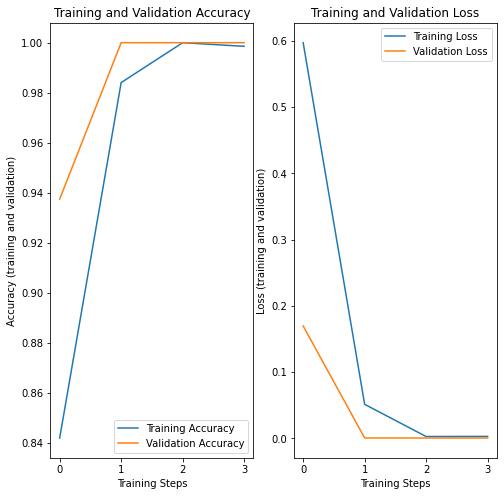

In [23]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

PREDICTED: class: cashew-anthracnose, confidence: 0.999948


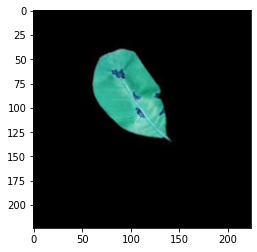

In [24]:
import cv2
# Utility
import itertools
import random
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from glob import iglob


img = cv2.imread("/content/quality-detection-2-v1-export/testing/cashew-anthracnose/cashew-anthracnose (28).jpg")
img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
img = img /255
probabilities = model.predict(np.asarray([img]))[0]
class_idx = np.argmax(probabilities)
classes = ["cashew-alive", "cashew-anthracnose"]
prediction = {classes[class_idx]: probabilities[class_idx]}
print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
plt.imshow(img)
#plt.figure(idx)    
plt.show()

In [25]:
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest', validation_split=0.2 )

In [27]:
#test_subset_data_dir = "data/test_subset"

test_subset_generator = test_datagen.flow_from_directory(
test_dir,
batch_size = BATCH_SIZE,
target_size = IMAGE_SIZE,
class_mode = "categorical",
shuffle=False)

Found 220 images belonging to 2 classes.


In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [40]:
Y_pred = model.predict_generator(test_subset_generator)
y_pred = np.argmax(Y_pred, axis=1)

img_nr = 0
for subdir, dirs, files in os.walk('test_dir'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file,target_size=(img_height,img_width))
        pred_emotion = category_names[y_pred[img_nr]]
        real_emotion = category_names[test_subset_generator.classes[img_nr]]
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion)
        plt.imshow(image)
        img_nr = img_nr +1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [1]:
Y_pred = model.predict_generator(test_subset_generator)
y_pred = np.argmax(Y_pred, axis=1)
category= ["cashew-alive","cashew-anthracnose"]
cm_aug = confusion_matrix(test_subset_generator.classes, y_pred)
plot_confusion_matrix(cm_aug, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_Augm.jpg')

NameError: ignored

In [38]:
Y_pred = model.predict_generator(test_subset_generator)
y_pred = np.argmax(Y_pred, axis=1)
accuracy = accuracy_score(test_subset_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy in test set: 100.0% 
